In [168]:
pip install matplotlib

You should consider upgrading via the '/Users/snow/.virtualenvs/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [169]:
pip install statsmodels

You should consider upgrading via the '/Users/snow/.virtualenvs/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [170]:
pip install tqdm

You should consider upgrading via the '/Users/snow/.virtualenvs/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
import statsmodels.api as sm
from tqdm import tqdm
from multiprocessing.dummy import Pool
import statsmodels.formula.api as smf
pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)

In [79]:
crsp_df = pd.read_csv("crsp.zip", compression='zip',header=0,
             parse_dates = ['date','DCLRDT','RCRDDT'],
             dtype={"PRC": np.float64,
                  "VOL": np.float64,
                  "SHROUT": np.float64,
                  "DIVAMT": np.float64,
                  "SPREAD": np.float64,
                  "SHRCD":str,
                  "DISTCD":str,
                  "COMNAM": str,
                  "TICKER": str,
                   'CUSIP': str})
#Data Preprocessing
crsp_df = crsp_df[(crsp_df.SHRCD.isin(('10','11')))]
crsp_df = crsp_df[(crsp_df.date >= '1927-01-01')]
crsp_df = crsp_df[(crsp_df.date <= '2011-12-31')]
cusips_DISTCD_12 = crsp_df[crsp_df.DISTCD.apply(lambda x: x[:2]=='12' if isinstance(x, str) else False)].CUSIP.unique()
crsp_df = crsp_df[crsp_df.CUSIP.isin(cusips_DISTCD_12)]

crsp_df.PRC = crsp_df.PRC.abs()


crsp_df['year'] = crsp_df['date'].dt.year
crsp_df['month'] = crsp_df['date'].dt.month
crsp_df.sort_values(by=['CUSIP','date'], ascending=True, inplace=True)
crsp_df['PRC_t-1'] = crsp_df.groupby('CUSIP')['PRC'].shift(1)
crsp_df.head()


,PERMNO,date,SHRCD,TICKER,COMNAM,CUSIP,DCLRDT,RCRDDT,DISTCD,DIVAMT,PRC,VOL,RET,SHROUT,SPREAD,RETX,year,month,PRC_t-1
1359100,25881,1970-11-30,10,AE,A & E PLASTIK PAK INC,00003210,NaT,NaT,NaN,NaN,9.000,318.0,C,2655.0,NaN,C,1970,11,NaN
1359101,25881,1970-12-31,10,AE,A & E PLASTIK PAK INC,00003210,NaT,NaT,NaN,NaN,10.000,646.0,0.111111,2655.0,NaN,0.111111,1970,12,9.000
1359102,25881,1971-01-29,10,AE,A & E PLASTIK PAK INC,00003210,NaT,NaT,NaN,NaN,9.000,636.0,-0.100000,2655.0,NaN,-0.100000,1971,1,10.000
1359103,25881,1971-02-26,10,AE,A & E PLASTIK PAK INC,00003210,NaT,NaT,NaN,NaN,11.125,2155.0,0.236111,2655.0,NaN,0.236111,1971,2,9.000
1359104,25881,1971-03-31,10,AE,A & E PLASTIK PAK INC,00003210,NaT,NaT,NaN,NaN,9.750,2062.0,-0.123596,2655.0,NaN,-0.123596,1971,3,11.125


In [80]:
crsp_div_df = crsp_df[['date','CUSIP','DCLRDT','RCRDDT','DISTCD','DIVAMT','PRC','PRC_t-1','RET','SHROUT','month']].copy()
crsp_div_df 
# crsp_div_df.sort_values(by=['CUSIP','date'], ascending=True, inplace=True)
crsp_div_df = crsp_div_df.groupby(by=['CUSIP','date']).agg({
     'DCLRDT': 'last',
     'RCRDDT': 'last',
     'DISTCD': 'last',
     'DIVAMT': 'last',
     'RET':'last',
     'PRC': 'last',
     'PRC_t-1': 'last',
     'SHROUT': 'last'})
# crsp_div_df.sort_values(by=['CUSIP','date'], ascending=True, inplace=True)
crsp_div_df['freq'] = None
crsp_div_df['freq'] = crsp_div_df[crsp_div_df.RCRDDT.isna()==False]['DISTCD'].apply(lambda x: x[2:3] if x is not None else None)

# fil_C = (crsp_div_df["PRC_t-1"] >= 5) & (crsp_div_df.freq < '6')
# crsp_div_df = crsp_div_df[fil_C]

crsp_div_df['MCAP'] = crsp_div_df['PRC'] * crsp_div_df['SHROUT']
crsp_div_df

DCLRDT RCRDDT DISTCD  DIVAMT        RET     PRC  PRC_t-1  \
CUSIP    date                                                                  
00003210 1970-11-30    NaT    NaT   None     NaN          C   9.000      NaN   
         1970-12-31    NaT    NaT   None     NaN   0.111111  10.000    9.000   
         1971-01-29    NaT    NaT   None     NaN  -0.100000   9.000   10.000   
         1971-02-26    NaT    NaT   None     NaN   0.236111  11.125    9.000   
         1971-03-31    NaT    NaT   None     NaN  -0.123596   9.750   11.125   
...                    ...    ...    ...     ...        ...     ...      ...   
N5946510 2011-08-31    NaT    NaT   None     NaN  -0.089113  20.750   22.780   
         2011-09-30    NaT    NaT   None     NaN  -0.181205  16.990   20.750   
         2011-10-31    NaT    NaT   None     NaN   0.151854  19.570   16.990   
         2011-11-30    NaT    NaT   None     NaN  -0.002044  19.530   19.570   
         2011-12-30    NaT    NaT   None     NaN   0.098822  21.460   19.530   

                       SHROUT freq         MCAP  
CUSIP    date                                    
00003210 1970-11-30    2655.0  NaN    23895.000  
         1970-12-31    2655.0  NaN    26550.000  
         1971-01-29    2655.0  NaN    23895.000  
         1971-02-26    2655.0  NaN    29536.875  
         1971-03-31    2655.0  NaN    25886.250  
...                       ...  ...          ...  
N5946510 2011-08-31  426263.0  NaN  8844957.250  
         2011-09-30  426485.0  NaN  7245980.150  
         2011-10-31  426512.0  NaN  8346839.840  
         2011-11-30  426512.0  NaN  8329779.360  
         2011-12-30  426678.0  NaN  9156509.880  

[2097733 rows x 10 columns]

In [81]:
crsp_div_df['div_yr']= crsp_div_df['freq']=='6'
crsp_div_df['div_semi_annual']= crsp_div_df['freq']=='4'
crsp_div_df['div_quarterly']= crsp_div_df['freq']=='3'
crsp_div_df['div_unknown']= crsp_div_df['freq']=='0'
crsp_div_df['div_monthly']= crsp_div_df['freq']=='2'

crsp_temp=crsp_div_df
crsp_temp['freq_2'] = crsp_temp['freq'].groupby(by=['CUSIP']).fillna(method='ffill', limit=11)
# crsp_temp['freq_2'].describe()

In [82]:
g = crsp_temp.groupby('CUSIP')['div_unknown']
crsp_temp['lag_u_1']=g.shift(1)
crsp_temp['lag_u_2']=g.shift(2)
crsp_temp['lag_u_3']=g.shift(3)
crsp_temp['lag_u_4']=g.shift(4)
crsp_temp['lag_u_5']=g.shift(5)
crsp_temp['lag_u_6']=g.shift(6)
crsp_temp['lag_u_7']=g.shift(7)
crsp_temp['lag_u_8']=g.shift(8)
crsp_temp['lag_u_9']=g.shift(9)
crsp_temp['lag_u_10']=g.shift(10)
crsp_temp['lag_u_11']=g.shift(11)
crsp_temp['lag_u_12']=g.shift(12)


crsp_temp['lag_quarterly']=crsp_temp.groupby('CUSIP')['div_quarterly'].shift(3)
crsp_temp['lag_semi_annual_six']=crsp_temp.groupby('CUSIP')['div_semi_annual'].shift(6)
crsp_temp['lag_semi_annual_twl']=crsp_temp.groupby('CUSIP')['div_semi_annual'].shift(12)
crsp_temp['lag_div_yr']=crsp_temp.groupby('CUSIP')['div_yr'].shift(12)

g_mon = crsp_temp.groupby('CUSIP')['div_monthly']

crsp_temp['lag_1']=g_mon.shift(1)
crsp_temp['lag_2']=g_mon.shift(2)
crsp_temp['lag_3']=g_mon.shift(3)
crsp_temp['lag_4']=g_mon.shift(4)
crsp_temp['lag_5']=g_mon.shift(5)
crsp_temp['lag_6']=g_mon.shift(6)
crsp_temp['lag_7']=g_mon.shift(7)
crsp_temp['lag_8']=g_mon.shift(8)
crsp_temp['lag_9']=g_mon.shift(9)
crsp_temp['lag_10']=g_mon.shift(10)
crsp_temp['lag_11']=g_mon.shift(11)
crsp_temp['lag_12']=g_mon.shift(12)

crsp_temp

DCLRDT RCRDDT DISTCD  DIVAMT        RET     PRC  PRC_t-1  \
CUSIP    date                                                                  
00003210 1970-11-30    NaT    NaT   None     NaN          C   9.000      NaN   
         1970-12-31    NaT    NaT   None     NaN   0.111111  10.000    9.000   
         1971-01-29    NaT    NaT   None     NaN  -0.100000   9.000   10.000   
         1971-02-26    NaT    NaT   None     NaN   0.236111  11.125    9.000   
         1971-03-31    NaT    NaT   None     NaN  -0.123596   9.750   11.125   
...                    ...    ...    ...     ...        ...     ...      ...   
N5946510 2011-08-31    NaT    NaT   None     NaN  -0.089113  20.750   22.780   
         2011-09-30    NaT    NaT   None     NaN  -0.181205  16.990   20.750   
         2011-10-31    NaT    NaT   None     NaN   0.151854  19.570   16.990   
         2011-11-30    NaT    NaT   None     NaN  -0.002044  19.530   19.570   
         2011-12-30    NaT    NaT   None     NaN   0.098822  21.460   19.530   

                       SHROUT freq         MCAP  ...  lag_3  lag_4  lag_5  \
CUSIP    date                                    ...                        
00003210 1970-11-30    2655.0  NaN    23895.000  ...    NaN    NaN    NaN   
         1970-12-31    2655.0  NaN    26550.000  ...    NaN    NaN    NaN   
         1971-01-29    2655.0  NaN    23895.000  ...    NaN    NaN    NaN   
         1971-02-26    2655.0  NaN    29536.875  ...  False    NaN    NaN   
         1971-03-31    2655.0  NaN    25886.250  ...  False  False    NaN   
...                       ...  ...          ...  ...    ...    ...    ...   
N5946510 2011-08-31  426263.0  NaN  8844957.250  ...  False  False  False   
         2011-09-30  426485.0  NaN  7245980.150  ...  False  False  False   
         2011-10-31  426512.0  NaN  8346839.840  ...  False  False  False   
         2011-11-30  426512.0  NaN  8329779.360  ...  False  False  False   
         2011-12-30  426678.0  NaN  9156509.880  ...  False  False  False   

                     lag_6  lag_7  lag_8  lag_9 lag_10 lag_11 lag_12  
CUSIP    date                                                         
00003210 1970-11-30    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
         1970-12-31    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
         1971-01-29    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
         1971-02-26    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
         1971-03-31    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
...                    ...    ...    ...    ...    ...    ...    ...  
N5946510 2011-08-31  False  False  False  False  False  False  False  
         2011-09-30  False  False  False  False  False  False  False  
         2011-10-31  False  False  False  False  False  False  False  
         2011-11-30  False  False  False  False  False  False  False  
         2011-12-30  False  False  False  False  False  False  False  

[2097733 rows x 37 columns]

In [83]:
# Strategies 1: Long predicted dividend and short all other companies
crsp_temp['long_stocks'] = (crsp_temp['lag_u_3'] | crsp_temp['lag_u_6'] | crsp_temp['lag_u_9'] | crsp_temp['lag_u_12'] | crsp_temp['lag_quarterly'] | crsp_temp['lag_semi_annual_six'] | crsp_temp['lag_semi_annual_twl'] | crsp_temp['lag_div_yr']) & (crsp_temp['PRC_t-1'] >=5) & (crsp_temp['freq_2']<='6')

crsp_temp.RET = crsp_temp.RET.apply(lambda x: x if str(x)[-1].isdigit() else np.nan)
crsp_temp['RET'] = crsp_temp['RET'].astype('float64')
crsp_temp
# crsp_temp['short_stocks'] = np.where(crsp_temp['long_stocks']==False,True,False)
# crsp_temp['short_stocks'] =  (crsp_temp['long_stocks'] == False) & (crsp_temp['PRC_t-1'] >=5)

# Strategies 2: Long predicted dividend and short all other dividend payers companies
crsp_temp['short_stocks'] = ( crsp_temp['lag_u_1'] | crsp_temp['lag_u_2']  | crsp_temp['lag_u_4']  | crsp_temp['lag_u_5'] | crsp_temp['lag_u_7']  | crsp_temp['lag_u_8']  | crsp_temp['lag_u_10']  | crsp_temp['lag_u_11'] | crsp_temp['lag_1'] | crsp_temp['lag_2']  |  crsp_temp['lag_3'] | crsp_temp['lag_4']  | crsp_temp['lag_5']  |  crsp_temp['lag_6']  | crsp_temp['lag_7']  | crsp_temp['lag_8'] | crsp_temp['lag_9'] | crsp_temp['lag_10']  | crsp_temp['lag_11']  | crsp_temp['lag_12']  ) & (crsp_temp['freq_2'] <= '6') & (crsp_temp['PRC_t-1'] >=5) & (crsp_temp['long_stocks'] == False)

# Strategies 3: Long predicted dividend and short all months occurring 1,4,7 or 10 months ago
# crsp_temp['short_stocks'] = (crsp_temp['lag_1'] | crsp_temp['lag_4']  | crsp_temp['lag_7']  | crsp_temp['lag_10'] ) &  (crsp_temp['freq_2']<='6') & (crsp_temp['PRC_t-1'] >=5) & (crsp_temp['long_stocks'] == False)
# crsp_temp['short_stocks'].describe()



In [84]:
# crsp_temp['short_stocks'].groupby('date').sum()
crsp_temp

DCLRDT RCRDDT DISTCD  DIVAMT       RET     PRC  PRC_t-1  \
CUSIP    date                                                                 
00003210 1970-11-30    NaT    NaT   None     NaN       NaN   9.000      NaN   
         1970-12-31    NaT    NaT   None     NaN  0.111111  10.000    9.000   
         1971-01-29    NaT    NaT   None     NaN -0.100000   9.000   10.000   
         1971-02-26    NaT    NaT   None     NaN  0.236111  11.125    9.000   
         1971-03-31    NaT    NaT   None     NaN -0.123596   9.750   11.125   
...                    ...    ...    ...     ...       ...     ...      ...   
N5946510 2011-08-31    NaT    NaT   None     NaN -0.089113  20.750   22.780   
         2011-09-30    NaT    NaT   None     NaN -0.181205  16.990   20.750   
         2011-10-31    NaT    NaT   None     NaN  0.151854  19.570   16.990   
         2011-11-30    NaT    NaT   None     NaN -0.002044  19.530   19.570   
         2011-12-30    NaT    NaT   None     NaN  0.098822  21.460   19.530   

                       SHROUT  freq         MCAP  ...  lag_5  lag_6  lag_7  \
CUSIP    date                                     ...                        
00003210 1970-11-30    2655.0  None    23895.000  ...   None   None   None   
         1970-12-31    2655.0  None    26550.000  ...   None   None   None   
         1971-01-29    2655.0  None    23895.000  ...   None   None   None   
         1971-02-26    2655.0  None    29536.875  ...   None   None   None   
         1971-03-31    2655.0  None    25886.250  ...   None   None   None   
...                       ...   ...          ...  ...    ...    ...    ...   
N5946510 2011-08-31  426263.0   NaN  8844957.250  ...  False  False  False   
         2011-09-30  426485.0   NaN  7245980.150  ...  False  False  False   
         2011-10-31  426512.0   NaN  8346839.840  ...  False  False  False   
         2011-11-30  426512.0   NaN  8329779.360  ...  False  False  False   
         2011-12-30  426678.0   NaN  9156509.880  ...  False  False  False   

                     lag_8  lag_9 lag_10 lag_11 lag_12 long_stocks  \
CUSIP    date                                                        
00003210 1970-11-30   None   None   None   None   None       False   
         1970-12-31   None   None   None   None   None       False   
         1971-01-29   None   None   None   None   None       False   
         1971-02-26   None   None   None   None   None       False   
         1971-03-31   None   None   None   None   None       False   
...                    ...    ...    ...    ...    ...         ...   
N5946510 2011-08-31  False  False  False  False  False       False   
         2011-09-30  False  False  False  False  False       False   
         2011-10-31  False  False  False  False  False       False   
         2011-11-30  False  False  False  False  False       False   
         2011-12-30  False  False  False  False  False       False   

                    lag_10 lag_month long_stocks short_stocks  
CUSIP    date                                                  
00003210 1970-11-30    NaN       NaN       False        False  
         1970-12-31    NaN     False       False        False  
         1971-01-29    NaN     False       False        False  
         1971-02-26    NaN     False       False        False  
         1971-03-31    NaN     False       False        False  
...                    ...       ...         ...          ...  
N5946510 2011-08-31  False     False       False        False  
         2011-09-30  False     False       False        False  
         2011-10-31  False     False       False        False  
         2011-11-30  False     False       False        False  
         2011-12-30  False     False       False        False  

[2097733 rows x 46 columns]

In [85]:
def long_short_weights(group):
    group['long_weight'] = np.nan
    longs = group.loc[group['long_stocks'] == True]
    group.loc[group['long_stocks']==True, 'long_weight'] = longs['MCAP_t-1'].groupby('date').apply(lambda x: x/ x.sum())
    # group['long_weight'] = group['long_weight'].groupby('CUSIP').shift(1)

    group['short_weight'] = np.nan
    # fil_short = group['long_stocks'] == False
    fil_short = group.short_stocks
    shorts = group.loc[fil_short]
    group.loc[fil_short, 'short_weight'] = shorts['MCAP_t-1'].groupby('date').apply(lambda x: x/ x.sum())
    # group['short_weight'] = group['short_weight'].groupby('CUSIP').shift(1)
    return group

def cal_return_vw(df):

    df['port_return_long_vw'] = df['RET'] * df['long_weight']
    longport = df['port_return_long_vw'].groupby('date').sum()

    df['port_return_short_vw'] = df['RET'] * df['short_weight']
    shortport = df['port_return_short_vw'].groupby('date').sum()

    data=pd.merge(longport, shortport, on='date', suffixes=['_long', '_short'])
    data['longshort_vw'] = data.port_return_long_vw  - data.port_return_short_vw
    data['cum_vw'] = (data.longshort_vw + 1).cumprod()

    return longport,shortport,data

def cal_return_eq(group):
    #Kobe Updated part, 
    longs = group.loc[group['long_stocks'] == True]
    longport = longs.RET.groupby('date').mean() 

    # fil_short = group['long_stocks'] == False
    fil_short = group.short_stocks
    shorts = group.loc[fil_short]
    shortport = shorts.RET.groupby('date').mean()
    
    data=pd.merge(longport, shortport, on='date', suffixes=['_long', '_short'])
    data['longshort_eq'] = data.RET_long  - data.RET_short
    data['cum_ew'] = (data.longshort_eq + 1).cumprod()
    # print(data)
    # print(shortport)
    # print(longshortport)
    
    return longport,shortport,data

crsp_temp['MCAP_t-1'] = crsp_temp.MCAP.groupby('CUSIP').shift(1)
# crsp_temp2 = 
panel=long_short_weights(crsp_temp)
longport_vw,shortport_vw,longshortport_vw=cal_return_vw(panel)
longport_eq,shortport_eq,longshortport_eq=cal_return_eq(crsp_temp)

longshortport_eq

,RET_long,RET_short,longshort_eq,cum_ew
date,,,,
1927-04-30,0.006961,0.025460,-0.018498,0.981502
1927-05-31,0.046389,0.041820,0.004568,0.985986
1927-06-30,-0.020347,-0.011561,-0.008786,0.977323
1927-07-30,0.062049,0.051824,0.010226,0.987317
1927-08-31,0.024969,0.024025,0.000943,0.988248
...,...,...,...,...
2011-08-31,-0.059962,-0.077010,0.017048,57.440829
2011-09-30,-0.079461,-0.103656,0.024195,58.830605
2011-10-31,0.130658,0.124094,0.006564,59.216761


In [86]:
# df.reset_index().groupby('date').sum().describe()
# panel.short_weight.groupby('date').sum()
# panel
# longshortport_vw.head(500)
longshortport_vw

,port_return_long_vw,port_return_short_vw,longshort_vw,cum_vw
date,,,,
1927-01-31,0.000000,0.000000,0.000000,1.000000
1927-02-28,0.000000,0.020954,-0.020954,0.979046
1927-03-31,0.000000,0.026414,-0.026414,0.953185
1927-04-30,0.013443,0.009498,0.003945,0.956946
1927-05-31,0.057629,0.045757,0.011872,0.968307
...,...,...,...,...
2011-08-31,-0.050080,-0.128124,0.078044,5.951425
2011-09-30,-0.075683,-0.166720,0.091037,6.493224
2011-10-31,0.116841,0.135574,-0.018733,6.371587


In [87]:
longshortport_vw

,port_return_long_vw,port_return_short_vw,longshort_vw,cum_vw
date,,,,
1927-01-31,0.000000,0.000000,0.000000,1.000000
1927-02-28,0.000000,0.020954,-0.020954,0.979046
1927-03-31,0.000000,0.026414,-0.026414,0.953185
1927-04-30,0.013443,0.009498,0.003945,0.956946
1927-05-31,0.057629,0.045757,0.011872,0.968307
...,...,...,...,...
2011-08-31,-0.050080,-0.128124,0.078044,5.951425
2011-09-30,-0.075683,-0.166720,0.091037,6.493224
2011-10-31,0.116841,0.135574,-0.018733,6.371587


In [88]:
ff4=pd.read_csv('four_factor_monthly.csv',index_col='date')
liq_df=pd.read_csv('liq_monthly.csv',index_col='date')
# merging with liquidity dataset
# ff4['merge_date']=ff4['date'].apply(lambda x: str(x)[0:7].replace('-',''))
# ff4 = ff4.set_index('merge_date')
# ff4.index=ff4.index.astype(str).astype(int)

# liquid_df= pd.read_csv('liq_data.csv',index_col='date')
# liq_df = pd.merge(ff4, liquid_df, how='inner', left_index=True, right_index=True)

# liq_df.to_csv('liq_monthly.csv',index='False')
ff4.index = pd.to_datetime(ff4.index)
liq_df.index = pd.to_datetime(liq_df.index)
liq_df

,Unnamed: 0,mkt_rf,smb,hml,rf,Mom,liq,Unnamed: 2
date,,,,,,,,
1970-11-30,197011,0.046048,-0.038764,0.014840,0.004610,0.022107,-0.005801,NaN
1970-12-31,197012,0.057196,0.027770,0.008493,0.004188,-0.023865,0.051033,NaN
1971-01-31,197101,0.048245,0.070373,0.013047,0.003807,-0.065202,-0.052025,NaN
1971-02-28,197102,0.014028,0.018771,-0.012779,0.003235,0.011666,-0.020223,NaN
1971-03-31,197103,0.041488,0.024413,-0.037557,0.002994,-0.009063,0.017893,NaN
...,...,...,...,...,...,...,...,...
2020-06-30,202006,0.025170,0.028277,-0.017412,0.000000,-0.031745,0.062176,NaN
2020-07-31,202007,0.057269,-0.020489,-0.014042,0.000000,0.058925,-0.012027,NaN
2020-08-31,202008,0.076499,-0.002268,-0.028171,0.000000,-0.000850,0.034763,NaN


In [89]:
pd.merge(ff4, longport_eq, on='date')

,mkt_rf,smb,hml,rf,Mom,RET
date,,,,,,
1927-04-30,0.005123,0.004924,0.004737,0.002503,0.041533,0.006961
1927-05-31,0.053512,0.013014,0.047367,0.003004,0.035404,0.046389
1927-06-30,-0.023892,0.003808,-0.015245,0.002503,0.020166,-0.020347
1927-08-31,0.020027,-0.007575,-0.035480,0.002704,0.026867,0.024969
1927-09-30,0.048230,-0.033924,-0.006663,0.002002,0.027053,0.041774
...,...,...,...,...,...,...
2011-06-30,-0.017457,-0.000473,-0.004444,0.000000,0.018392,-0.008350
2011-08-31,-0.059974,-0.028293,-0.024706,0.000000,-0.002962,-0.059962
2011-09-30,-0.075968,-0.034320,-0.015275,0.000000,0.023169,-0.079461


In [90]:
# equal_weighted_long
# data=pd.merge(ff4, longport_eq, on='date')

print (
    smf.ols('RET ~ 1 + hml + mkt_rf + smb + Mom', data=pd.merge(ff4, longport_eq, on='date'))
    .fit().summary()
)

# equal_weighted_short
print (
    smf.ols('RET ~ 1 + hml + mkt_rf + smb + Mom', data=pd.merge(ff4, shortport_eq, on='date'))
    .fit().summary()
)
# equal_weighted_diff
print (
    smf.ols('longshort_eq ~ 1 + hml + mkt_rf + smb + Mom', data=pd.merge(ff4, longshortport_eq, on='date'))
    .fit().summary()
)

                            OLS Regression Results                            
Dep. Variable:                    RET   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     1882.
Date:                Mon, 31 May 2021   Prob (F-statistic):               0.00
Time:                        01:36:51   Log-Likelihood:                 1996.7
No. Observations:                 743   AIC:                            -3983.
Df Residuals:                     738   BIC:                            -3960.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0085      0.001     13.714      0.0

In [91]:
# value_weighted_long
data=pd.merge(ff4, longport_eq, on='date')

print (
    smf.ols('port_return_long_vw ~ 1 + hml + mkt_rf + smb + Mom', data=pd.merge(ff4, longport_vw, on='date'))
    .fit().summary()
)

# value_weighted_short
print (
    smf.ols('port_return_short_vw ~ 1 + hml + mkt_rf + smb + Mom', data=pd.merge(ff4, shortport_vw, on='date'))
    .fit().summary()
)
# value_weighted_diff
print
(
    smf.ols('longshort_vw ~ 1 + hml + mkt_rf + smb + Mom', data=pd.merge(ff4, longshortport_vw, on='date'))
    .fit().summary()
)

                             OLS Regression Results                            
Dep. Variable:     port_return_long_vw   R-squared:                       0.899
Model:                             OLS   Adj. R-squared:                  0.899
Method:                  Least Squares   F-statistic:                     1653.
Date:                 Mon, 31 May 2021   Prob (F-statistic):               0.00
Time:                         01:36:51   Log-Likelihood:                 2032.0
No. Observations:                  747   AIC:                            -4054.
Df Residuals:                      742   BIC:                            -4031.
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0054      0.001      8.91

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           longshort_vw   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     28.52
Date:                Mon, 31 May 2021   Prob (F-statistic):           4.56e-22
Time:                        01:36:51   Log-Likelihood:                 1560.4
No. Observations:                 747   AIC:                            -3111.
Df Residuals:                     742   BIC:                            -3088.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0024      0.001      2.159      0.031       0.000       0.005
hml            0.2507      0.034      7.437      0.000       0.185       0.317
mkt_rf        -0.1532      0.023     -6.720      0.000      -0.198      -0.108
smb           -0.0882      0.036     -2.451      0.014      -0.159      -0.018
Mom           -0.0608      0.026     -2.381      0.018      -0.111      -0.011
==============================================================================
Omnibus:                      117.175   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1256.723
Skew:                          -0.293   Prob(JB):                    1.28e-273
Kurtosis:                       9.327   Cond. No.                         34.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [92]:
# panel B do one strategies 1 & 2 
# CAPM Alpha

print( smf.ols('RET ~ 1 + mkt_rf', data=pd.merge(ff4, longport_eq, on='date')) .fit().summary())


# equal_weighted_short
print (
    smf.ols('RET ~ 1 + mkt_rf ', data=pd.merge(ff4, shortport_eq, on='date'))
    .fit().summary()
)
# equal_weighted_diff
print (
    smf.ols('longshort_eq ~ 1 + mkt_rf', data=pd.merge(ff4, longshortport_eq, on='date'))
    .fit().summary()
)


                            OLS Regression Results                            
Dep. Variable:                    RET   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     5058.
Date:                Mon, 31 May 2021   Prob (F-statistic):               0.00
Time:                        01:36:51   Log-Likelihood:                 1863.5
No. Observations:                 743   AIC:                            -3723.
Df Residuals:                     741   BIC:                            -3714.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0084      0.001     11.572      0.0

In [93]:
# 3-factor Alpha  do one strategies 1 & 2 

print( smf.ols('RET ~ 1 + hml + mkt_rf + smb', data=pd.merge(ff4, longport_eq, on='date')) .fit().summary())


# equal_weighted_short
print (
    smf.ols('RET ~ 1 + hml + mkt_rf + smb ', data=pd.merge(ff4, shortport_eq, on='date'))
    .fit().summary()
)
# equal_weighted_diff
print (
    smf.ols('longshort_eq ~ 1 + hml + mkt_rf + smb', data=pd.merge(ff4, longshortport_eq, on='date'))
    .fit().summary()
)

                            OLS Regression Results                            
Dep. Variable:                    RET   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     2397.
Date:                Mon, 31 May 2021   Prob (F-statistic):               0.00
Time:                        01:36:51   Log-Likelihood:                 1980.8
No. Observations:                 743   AIC:                            -3954.
Df Residuals:                     739   BIC:                            -3935.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0079      0.001     12.602      0.0

In [94]:
# 4-factor Alpha  do one strategies 1 & 2 

print( smf.ols('RET ~ 1 + hml + mkt_rf + smb + Mom', data=pd.merge(ff4, longport_eq, on='date')) .fit().summary())


# equal_weighted_short
print (
    smf.ols('RET ~ 1 + hml + mkt_rf + smb + Mom', data=pd.merge(ff4, shortport_eq, on='date'))
    .fit().summary()
)
# equal_weighted_diff
print (
    smf.ols('longshort_eq ~ 1 + hml + mkt_rf + smb + Mom', data=pd.merge(ff4, longshortport_eq, on='date'))
    .fit().summary()
)

                            OLS Regression Results                            
Dep. Variable:                    RET   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     1882.
Date:                Mon, 31 May 2021   Prob (F-statistic):               0.00
Time:                        01:36:51   Log-Likelihood:                 1996.7
No. Observations:                 743   AIC:                            -3983.
Df Residuals:                     738   BIC:                            -3960.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0085      0.001     13.714      0.0

In [95]:
# liquidity Alpha for strategies 1 & 2 

print( smf.ols('RET ~ 1 + hml + mkt_rf + smb + Mom + liq', data=pd.merge(liq_df, longport_eq, on='date')) .fit().summary())


# equal_weighted_short
print (
    smf.ols('RET ~ 1 + hml + mkt_rf + smb + Mom + liq ', data=pd.merge(liq_df, shortport_eq, on='date'))
    .fit().summary()
)
# equal_weighted_diff
print (
    smf.ols('longshort_eq ~ 1 + hml + mkt_rf + smb + Mom +liq', data=pd.merge(liq_df, longshortport_eq, on='date'))
    .fit().summary()
)

                            OLS Regression Results                            
Dep. Variable:                    RET   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     623.9
Date:                Mon, 31 May 2021   Prob (F-statistic):          7.66e-169
Time:                        01:36:51   Log-Likelihood:                 976.60
No. Observations:                 346   AIC:                            -1941.
Df Residuals:                     340   BIC:                            -1918.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0093      0.001     11.241      0.0

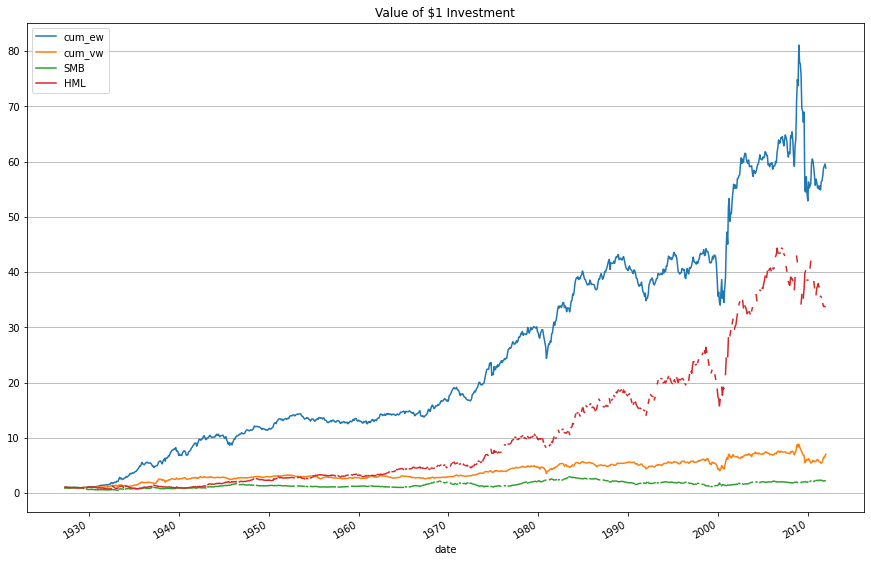

In [96]:
# Figure 1
portfolios = pd.DataFrame()
portfolios['cum_ew'] = (longshortport_eq['longshort_eq'] + 1).cumprod()
# print(portfolios['cum_ew'])
portfolios['cum_vw'] = (longshortport_vw['longshort_vw'] + 1).cumprod()
portfolios['SMB']= (ff4['smb']+ 1).cumprod()
portfolios['HML']= (ff4['hml']+ 1).cumprod()
portfolios=portfolios.reset_index()
portfolios
# Within-companies Predicted Dividend Portfolio
(
    portfolios
    .assign(date=pd.to_datetime(portfolios['date']))
    .assign(cum_ew=portfolios['cum_ew'])
    .assign(cum_vw=portfolios['cum_vw'])
    .assign(SMB=portfolios['SMB'])
    .assign(HML=portfolios['HML'])
    .plot(x='date', y=['cum_ew','cum_vw','SMB','HML'],figsize=(15,10),title='Value of $1 Investment').grid(axis='y')
)